### Students:
 Nicolas Charpentier

 Lydia Delgado Uriarte


#         BrakTooth Attack Dataset


The ISOT BrakTooth Attack dataset contains Bluetooth classic traffic from both normal Bluetooth communications and BrakTooth-based attacks.
In this notebook, we are training our data with different models to detect if there is an attack or not. 





## Import libraries and load data
Import **pandas** library to work with datasets, **numpy** library that support matrix operation, **matplotlib** library for plotting data.  

In [381]:
# Some libraries to install
!! pip install scikit-learn
!! pip install imbalanced-learn
!! pip install memory-profiler
!! pip install sns

['Requirement already satisfied: sns in /Users/lydiadelgado/anaconda3/lib/python3.11/site-packages (0.1)']

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [383]:
#pd.set_option('display.max_rows', None)

# Read the csv
We will use pandas to read a csv and make the csv a DataFrame.

In [384]:
# We read the csv in 
X_test = pd.read_csv("X_test.csv")
dataset = pd.read_csv("X_train.csv")

In [385]:
# 
dataset.all()

Protocol     True
Info         True
Length       True
Delta       False
Type         True
dtype: bool

In [386]:
count_false = (dataset['Delta'] == False).sum()
print(f'False values in column Delta: {count_false}')
dataset["Info"].unique()

False values in column Delta: 4


array(['Rcvd Link Key Request', 'Sent Link Key Request Negative Reply',
       'Rcvd Command Complete (Link Key Request Negative Reply)',
       'LM Sent', 'LMP_au_rand', 'FHS', 'LMP_not_accepted', 'LM Received',
       'Rcvd Connect Request', 'Sent Accept Connection Request',
       'Rcvd Command Status (Accept Connection Request)',
       'Rcvd Connect Complete', 'Sent Read Clock offset',
       'Sent Information Request (Extended Features Mask)',
       'Rcvd Max Slots Change',
       'Rcvd Connection Request (SDP, SCID: 0x0041)',
       'Rcvd Command Status (Read Clock offset)',
       'Sent Read Remote Version Information',
       'Sent Connection Response - Pending (SCID: 0x0041)',
       'Rcvd Read Clock Offset Complete',
       'Rcvd Command Status (Read Remote Version Information)',
       'Sent Read Remote Supported Features',
       'Rcvd Read Remote Version Information Complete',
       'Rcvd Command Status (Read Remote Supported Features)',
       'Sent Remote Name Request

In [387]:
mask = (dataset['Delta'] == False)

# Imprime los valores False
print(dataset.loc[mask, 'Delta'])

1661    0.0
1896    0.0
2116    0.0
2249    0.0
Name: Delta, dtype: float64


In [388]:
# Check if we have duplicated values or null values
print(f"Null values:\n{dataset.isna().sum()}\n")
print(f"Duplicated values: {dataset.duplicated().sum()}")

Null values:
Protocol    0
Info        0
Length      0
Delta       0
Type        0
dtype: int64

Duplicated values: 0


In [389]:
# Check the types we have for the protocols
print(dataset["Type"].unique())
print(dataset["Protocol"].unique())

['au_rand_flooding' 'duplicated_encapsulated_payload' 'duplicated_iocap'
 'truncated_sco_link_request' 'feature_response_flooding'
 'invalid_feature_page_execution' 'lmp_auto_rate_overflow'
 'lmp_overflow_dm1' 'truncated_lmp_accepted' 'invalid_setup_complete'
 'invalid_timing_accuracy' 'normal']
['HCI_EVT' 'HCI_CMD' 'HCI H4 Broadcom' 'LMP' 'Baseband' 'L2CAP' 'SDP'
 'BNEP' 'RFCOMM' 'OBEX']


In [390]:
dataset["Protocol"].describe()

count     6402
unique      10
top       OBEX
freq      2575
Name: Protocol, dtype: object

# Check the count of the Protocols
To see how the number of total protocols are distributed, we incorporate a bar graph and as well a table from ascendent to descendent in order to visualize which protocol attack .


In [391]:
# Count the occurrences of each protocol
#dataset = dataset.shape()
protocol_counts = dataset['Protocol'].value_counts()
protocol_counts

OBEX               2575
LMP                1546
HCI_EVT             964
RFCOMM              638
HCI_CMD             287
L2CAP               231
Baseband             78
SDP                  44
HCI H4 Broadcom      37
BNEP                  2
Name: Protocol, dtype: int64

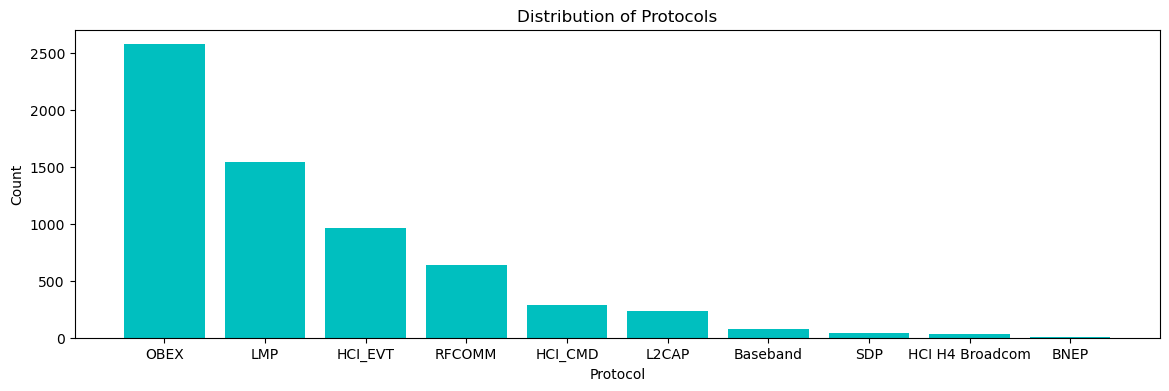

In [392]:
# Create a bar plot using Matplotlib
plt.figure(figsize=(14, 4))
plt.bar(protocol_counts.index, protocol_counts.values, color='c')
plt.title('Distribution of Protocols')
plt.grid(False)
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

In [393]:
type_counts = dataset['Type'].value_counts()
type_counts

normal                             4055
au_rand_flooding                    526
truncated_sco_link_request          304
duplicated_iocap                    277
invalid_feature_page_execution      239
truncated_lmp_accepted              236
invalid_timing_accuracy             188
feature_response_flooding           161
lmp_overflow_dm1                    142
lmp_auto_rate_overflow              124
duplicated_encapsulated_payload      94
invalid_setup_complete               56
Name: Type, dtype: int64

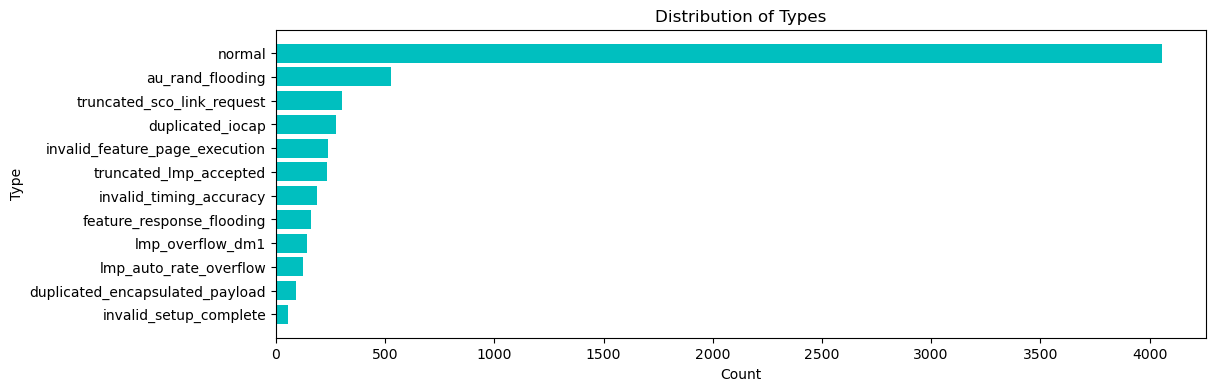

In [394]:
# Create a bar plot using Matplotlib
plt.figure(figsize=(12, 4))
plt.barh(type_counts.index, type_counts.values, color='c')
plt.title('Distribution of Types')
plt.gca().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

In [395]:
# Rename the columns if its not normal, then it will be attack
dataset["Type"] = dataset["Type"].str.replace("normal", "No Attack")
# Numpy where to check where values are different from no attack
dataset["Type"] = np.where(dataset["Type"]!= "No Attack", "Attack", dataset["Type"])


In [396]:
type_counts = dataset['Type'].value_counts()
type_counts

No Attack    4055
Attack       2347
Name: Type, dtype: int64

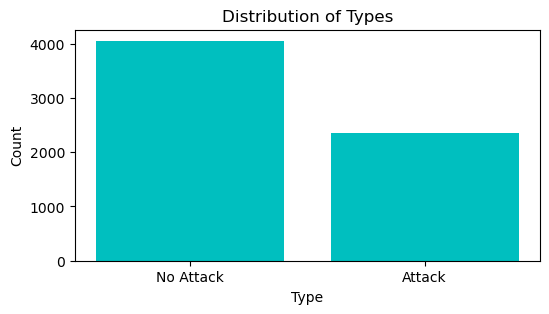

In [397]:
# Create a bar plot using Matplotlib
plt.figure(figsize=(6, 3))
plt.bar(type_counts.index, type_counts.values, color='c')
plt.title('Distribution of Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

## Clean our information
Seeing the info column, we can see that the dataset have repeated values as well after the "()" characters or "-" character. In this case, we would implement a method to delete the rest of the string if it detects one of this special characters.

In [398]:
dataset["Info"].unique()

array(['Rcvd Link Key Request', 'Sent Link Key Request Negative Reply',
       'Rcvd Command Complete (Link Key Request Negative Reply)',
       'LM Sent', 'LMP_au_rand', 'FHS', 'LMP_not_accepted', 'LM Received',
       'Rcvd Connect Request', 'Sent Accept Connection Request',
       'Rcvd Command Status (Accept Connection Request)',
       'Rcvd Connect Complete', 'Sent Read Clock offset',
       'Sent Information Request (Extended Features Mask)',
       'Rcvd Max Slots Change',
       'Rcvd Connection Request (SDP, SCID: 0x0041)',
       'Rcvd Command Status (Read Clock offset)',
       'Sent Read Remote Version Information',
       'Sent Connection Response - Pending (SCID: 0x0041)',
       'Rcvd Read Clock Offset Complete',
       'Rcvd Command Status (Read Remote Version Information)',
       'Sent Read Remote Supported Features',
       'Rcvd Read Remote Version Information Complete',
       'Rcvd Command Status (Read Remote Supported Features)',
       'Sent Remote Name Request

In [399]:
dataset

,Protocol,Info,Length,Delta,Type
0,HCI_EVT,Rcvd Link Key Request,9,0.010473,Attack
1,HCI_CMD,Sent Link Key Request Negative Reply,10,0.010473,Attack
2,HCI_EVT,Rcvd Link Key Request,9,0.017913,Attack
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,13,0.002642,Attack
4,HCI_CMD,Sent Link Key Request Negative Reply,10,0.002882,Attack
...,...,...,...,...,...
6397,RFCOMM,Sent UIH Channel=12 UID,14,0.006531,No Attack
6398,HCI_EVT,Rcvd Number of Completed Packets,8,0.004969,No Attack
6399,OBEX,Sent Continue,21,0.014489,No Attack
6400,LMP,LMP_power_control_req,64,0.003510,No Attack


In [400]:
X_test = pd.read_csv("X_test.csv")
X_test['Info'].unique()

array(['FHS', 'LM Received', 'LM Sent', 'LMP_accepted',
       'LMP_accepted_ext', 'LMP_au_rand', 'LMP_auto_rate',
       'LMP_channel_classification', 'LMP_channel_classification_req',
       'LMP_detach', 'LMP_features_req', 'LMP_features_req_ext',
       'LMP_features_res', 'LMP_features_res_ext',
       'LMP_host_connection_req', 'LMP_max_slot', 'LMP_max_slot_req',
       'LMP_not_accepted', 'LMP_not_accepted_ext',
       'LMP_packet_type_table_req', 'LMP_power_control_req',
       'LMP_power_control_res', 'LMP_set_AFH', 'LMP_setup_complete',
       'LMP_timing_accuracy_req', 'LMP_timing_accuracy_res',
       'LMP_version_req', 'LMP_version_res',
       'Rcvd Command Complete (Link Key Request Negative Reply)',
       'Rcvd Command Complete (Write Link Policy Settings)',
       'Rcvd Command Complete (Write Scan Enable)',
       'Rcvd Command Status (Accept Connection Request)',
       'Rcvd Command Status (Change Connection Packet Type)',
       'Rcvd Command Status (Read Clock of

In [401]:
dataset = dataset[dataset['Info'].isin(X_test['Info'].unique())]

dataset = dataset.reset_index(drop=True)
dataset

,Protocol,Info,Length,Delta,Type
0,HCI_EVT,Rcvd Link Key Request,9,0.010473,Attack
1,HCI_CMD,Sent Link Key Request Negative Reply,10,0.010473,Attack
2,HCI_EVT,Rcvd Link Key Request,9,0.017913,Attack
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,13,0.002642,Attack
4,HCI_CMD,Sent Link Key Request Negative Reply,10,0.002882,Attack
...,...,...,...,...,...
5906,RFCOMM,Sent UIH Channel=12 UID,14,0.006531,No Attack
5907,HCI_EVT,Rcvd Number of Completed Packets,8,0.004969,No Attack
5908,OBEX,Sent Continue,21,0.014489,No Attack
5909,LMP,LMP_power_control_req,64,0.003510,No Attack


In [402]:
dataset.count()

Protocol    5911
Info        5911
Length      5911
Delta       5911
Type        5911
dtype: int64

In [403]:
dataset

,Protocol,Info,Length,Delta,Type
0,HCI_EVT,Rcvd Link Key Request,9,0.010473,Attack
1,HCI_CMD,Sent Link Key Request Negative Reply,10,0.010473,Attack
2,HCI_EVT,Rcvd Link Key Request,9,0.017913,Attack
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,13,0.002642,Attack
4,HCI_CMD,Sent Link Key Request Negative Reply,10,0.002882,Attack
...,...,...,...,...,...
5906,RFCOMM,Sent UIH Channel=12 UID,14,0.006531,No Attack
5907,HCI_EVT,Rcvd Number of Completed Packets,8,0.004969,No Attack
5908,OBEX,Sent Continue,21,0.014489,No Attack
5909,LMP,LMP_power_control_req,64,0.003510,No Attack


## Explanation of the dataset
The dataframe is divided into different columns 
- Protocol: Used in the Bluetooth Packet
- Info: Provides information about each packet and depends on the type of protocol
- Length: It's the length of the packet in bytes
- Delta:Time difference between current packet and previous packet
- Type: It represents normal vs attack conditions, labelled manually. <- dependent variable

In [404]:
dataset

,Protocol,Info,Length,Delta,Type
0,HCI_EVT,Rcvd Link Key Request,9,0.010473,Attack
1,HCI_CMD,Sent Link Key Request Negative Reply,10,0.010473,Attack
2,HCI_EVT,Rcvd Link Key Request,9,0.017913,Attack
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,13,0.002642,Attack
4,HCI_CMD,Sent Link Key Request Negative Reply,10,0.002882,Attack
...,...,...,...,...,...
5906,RFCOMM,Sent UIH Channel=12 UID,14,0.006531,No Attack
5907,HCI_EVT,Rcvd Number of Completed Packets,8,0.004969,No Attack
5908,OBEX,Sent Continue,21,0.014489,No Attack
5909,LMP,LMP_power_control_req,64,0.003510,No Attack


## We will shape our data 

In [405]:
dataset

X = dataset['Length'].shape
y = dataset['Type'].shape
X


(5911,)

## Transform the string values into numerical values so we can work with them in the X dataset.
We will be using the library OneHotEncoder and we will add our values we want to transform in an array as strings, denoting the values taken on by categorical (discrete) features. 

In [406]:
from sklearn.preprocessing import OneHotEncoder

### Transform protocol data 
We will transform the string into numerical values
Once done this we will create a protocol dataframe

In [407]:
# Codificator Instance
onehot_encoder = OneHotEncoder()

# Codify the independent variable 
data_to_encode = dataset[['Protocol']]

# Column to numpy array
data_array = data_to_encode.values

#  reshape a data_array 
reshaped_data = data_array.reshape(-1, 1)

# Initialize decoder one-hot
onehot_encoder = OneHotEncoder()

# Adjust & transform data codifying 'Type'
onehot_encoded_protocol = onehot_encoder.fit_transform(reshaped_data)
categories = onehot_encoder.get_feature_names_out(input_features=['Protocol'])


In [408]:
# We transform the matrix into an array and save it in a dataframe 
protocoldf = pd.DataFrame(onehot_encoded_protocol.toarray(), columns= categories)


# Transform Info data 
We will transform the string into numerical values
Once done this we will create a info dataframe

In [409]:
# Codificator Instance
onehot_encoder = OneHotEncoder()

# Codify the independent variable 
data_to_encode = dataset[['Info']]

# Column to numpy array
data_array = data_to_encode.values

#  reshape a data_array 
reshaped_data = data_array.reshape(-1, 1)

# Initialize decoder one-hot
onehot_encoder = OneHotEncoder()

# Adjust & transform data codifying 'Type'
onehot_encoded_info = onehot_encoder.fit_transform(reshaped_data)
categories = onehot_encoder.get_feature_names_out(input_features=['Info'])
print(onehot_encoded_info.toarray().shape)

(5911, 59)


In [410]:
# We transform the matrix into an array and save it in a dataframe 
infodf = pd.DataFrame(onehot_encoded_info.toarray(), columns= categories)


# Assign our dependent variable
We will use the column Type from the dataset since is the way we're classifying our data

In [411]:
#Assign our variable y 
y = dataset["Type"]


In [412]:
y.head()
dataset["Info"]

0                                   Rcvd Link Key Request
1                    Sent Link Key Request Negative Reply
2                                   Rcvd Link Key Request
3       Rcvd Command Complete (Link Key Request Negati...
4                    Sent Link Key Request Negative Reply
                              ...                        
5906                             Sent UIH Channel=12 UID 
5907                     Rcvd Number of Completed Packets
5908                                        Sent Continue
5909                                LMP_power_control_req
5910                                LMP_power_control_res
Name: Info, Length: 5911, dtype: object

# Standardize values
Using the librarie Standard Scaler, we standardize our values Length and Delta since are the ones we have numerical since the beginning, we do this since standardization makes it easier to compare data points that have different units being **Length** bytes and **Delta** time units. 

By scaling the values to have a mean of 0 and a standard deviation of 1, we can compare the relative position of data points within their respective distributions.

Standardize features by removing the mean and scaling to unit variance.
The standard score of a sample x is calculated as:

$$ z = \frac{(x - u)}{s} $$

In [413]:
# We import Standard Scaler
from sklearn.preprocessing import StandardScaler

In [414]:
scaler = StandardScaler()
dataset['Length'] = scaler.fit_transform(np.array(dataset['Length']).reshape(-1, 1))
dataset['Delta'] = scaler.fit_transform(np.array(dataset['Delta']).reshape(-1, 1))
dataset.head(10)
dataset

,Protocol,Info,Length,Delta,Type
0,HCI_EVT,Rcvd Link Key Request,-0.861247,-0.008874,Attack
1,HCI_CMD,Sent Link Key Request Negative Reply,-0.859186,-0.008874,Attack
2,HCI_EVT,Rcvd Link Key Request,-0.861247,-0.004334,Attack
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,-0.853000,-0.013653,Attack
4,HCI_CMD,Sent Link Key Request Negative Reply,-0.859186,-0.013507,Attack
...,...,...,...,...,...
5906,RFCOMM,Sent UIH Channel=12 UID,-0.850939,-0.011280,No Attack
5907,HCI_EVT,Rcvd Number of Completed Packets,-0.863309,-0.012233,No Attack
5908,OBEX,Sent Continue,-0.836506,-0.006423,No Attack
5909,LMP,LMP_power_control_req,-0.747851,-0.013124,No Attack


## Append Dataframes

Now we're going to create a new dataframe with our new values standardized and transformed into numerical values. 

We will create two datasets to tests our model and see if there are changes in the number of features used.

### First dataset with all the features

In [415]:
# in this step we put our independents variables together and the dependent separate

# Boolean variable to check if the dataset is created
created = False

# Go through the function once 
if not created:
    # Create the first dataframe with the values
    new_dataset = pd.concat([protocoldf, infodf, dataset["Length"], dataset["Delta"]], axis=1)

    # Mark variable as true so it doesn't repeat if it is needed to rerun the whole program.
    created = True

In [416]:
X = new_dataset
X

,Protocol_Baseband,Protocol_HCI H4 Broadcom,Protocol_HCI_CMD,Protocol_HCI_EVT,Protocol_L2CAP,Protocol_LMP,Protocol_OBEX,Protocol_RFCOMM,Info_FHS,Info_LM Received,...,Info_Sent Information Request (Extended Features Mask),Info_Sent Link Key Request Negative Reply,Info_Sent Read Clock offset,Info_Sent Read Remote Extended Features,Info_Sent Read Remote Version Information,Info_Sent UIH Channel=12 UID,Info_Sent Write Link Policy Settings,Info_Sent Write Scan Enable,Length,Delta
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.861247,-0.008874
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.859186,-0.008874
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.861247,-0.004334
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.853000,-0.013653
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.859186,-0.013507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.850939,-0.011280
5907,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.863309,-0.012233
5908,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.836506,-0.006423
5909,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.747851,-0.013124


### Second dataset with features Delta and Length
We choose this values since are the ones numerical since the beginning and we will see if by not using the other features would affect or improve the accuracy of our model.

In [417]:
# in this step we put our independents variables together and the dependent separate

# Boolean variable to check if the dataset is created
second_created = False

# Go through the function once 
if not second_created:
    # Create the first dataframe with the values
    TwoX = pd.concat([dataset["Length"], dataset["Delta"]], axis=1)
    
    # Mark variable as true so it doesn't repeat if it is needed to rerun the whole program.
    second_created = True
    
    
TwoX.head()
TwoX

,Length,Delta
0,-0.861247,-0.008874
1,-0.859186,-0.008874
2,-0.861247,-0.004334
3,-0.853000,-0.013653
4,-0.859186,-0.013507
...,...,...
5906,-0.850939,-0.011280
5907,-0.863309,-0.012233
5908,-0.836506,-0.006423
5909,-0.747851,-0.013124


# Try the models

# Model assessment: Training set and testing set

## Split the data
First we split the data into training set and test set. We will train our model using the training set and to test it is the test set. We will implement a 

The library we're going to use train_test_split split arrays or matrices into random train and test subsets.

In [418]:
# Import our library to split our data into two sets
from sklearn.model_selection import train_test_split

In [419]:
seed = 42
# Dataset with all features. We choose test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Dataset with features Delta and Length, we choose this values since they
# are numerical without using any encoder
X_train2, X_test2, y_train2, y_test2 = train_test_split(TwoX, y, test_size=0.2, random_state=seed)


# Model Selection 

To know which model is more convenient for our problem, we would train some models and compare how well they fit each model, taking into consideration:
- Accuracy
- Compare the accuracy between test set and train set
- Computation times, memory used
- Simplest method for a better score 

Also, knowing that we are facing a classification problem we will try to find the more appropiate models for this, in this case is binary classification since it is divided only in two categories being **No Attack** and **Attack**.


### Confusion Matrix
This is a matrix that counts the classification classes. In this case we would count the Attacks and No Attacks **true positive** and also the **falses**.

$$
\begin{matrix}
        &          & & Predicted &  \\
        &          &  Negative   &  & Positive \\
        & Negative &     True Negative TN  &  & False Positive FP\\
Actual  &          & & & \\
        &  Positive  &   False Negative FN  & & True Positive TP
\end{matrix} 
$$

### Precision of the classifier
This returns the accuracy of the positives prediction made by the classifier.

The formula for this method:

$$precision = \frac{ TP  }{ TP + FP }$$

- TP true positives being the number of correctly predicted positive instances
- FP false positives being the number of negative instances incorrectly classified as positive.

### Recall
Known as sensitive or true positive rate (TPR), the classifier detects the correct positive instances ratio.

The equation for the Recall metric:

$$ F1 = \frac{TP}{TP + FN}$$

Tp is the number of True Positives and FN is the numver for False Negatives.

### F1 Score
This metric is Precision and Recall combined and is helpful in this problem since its useful to compare two classifiers. This metric would be only a high score if **precision** and **recall** are high.

Formula for recall:
$$ F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2  \times \frac{ precision \times recall}
{precision + recall} = \frac{TP}{{TP} + \frac{FN+FP}{2}}
 $$


## Import Performance Measure metrics

In [420]:
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# For calculate computation time
import time
# For calculate memory usage
import tracemalloc

# Try the models
We will create some lists to save the values for this models and at the end we can have a more clear panoram of which model is more suitable for detecting an attack.

In [421]:
models_name = list(range(1, 6))
computation_time = list(range(1, 6))
accuracy_model = list(range(1,6))
memory_usage = list(range(1,6))

# Decision Tree Classifier
This is a supervised learning algorithm meaning it learns how to map from input features to output labels, so that the algorithm can make accurate predictions for new, unseen data. 

This trees uses a top-down, greedy approach. In each split it maximize information gain or minimize impurity at the current node.

Decision trees uses 
- **Entropy**: Uncertainty in our dataset or measure of disorder. 

The formula for Entropy [3].

$  E(S) = - p_{(+)}logp_{(+)}-p_{(-)}logp_{(-)} $
- $ p_{+}$ is the probability of positive class
- $ p_{-}$ is the probability of negative class

The decision tree output is mostly yes or not. The higher the Entropy, the lower will be the purity and the higher will be the impurity. The objective of this model is to decrease the uncertainty or impurity in the dataset.

In [422]:
# Import library Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [423]:
# We create a function to create our model Decision Tree Classifier and we 
#fit our datasets X_train and y_train into the model.

clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [424]:
# We use the model method to predict the class labels for the provided data.
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [425]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))
# Create a matrix confusion based on our y_test and y_pred_test
cm = confusion_matrix(y_test, y_pred_test)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

print("\nConfusion Matrix")
display(cm_df)

report = classification_report(y_test, y_pred_test)
print("\n\nClassification Inform:")
print(classification_report(y_test, y_pred_test))

Predictions are 100.0% accurate on the training set.
Predictions are 97.5% accurate on the test set.

Confusion Matrix


,Predicted No Attack,Predicted Attack
Actual No Attack,440,12
Actual Attack,17,714




Classification Inform:
              precision    recall  f1-score   support

      Attack       0.96      0.97      0.97       452
   No Attack       0.98      0.98      0.98       731

    accuracy                           0.98      1183
   macro avg       0.97      0.98      0.97      1183
weighted avg       0.98      0.98      0.98      1183



### Overfitting issue !!
We can see that we have overfitting due the accuracy on the training set and test set, is visualized that the predictions are **100.0%** accurate on the training set, this happens when the model is too complex to the amount of data values.

Decision trees can suffer from overfitting when they incorporate noise from the data. 

To solve this we will constraint the model and change a parameter being the max_leaf_nodes of the decision tree classifier meaning we will try to change the model to modify this parameter. 
The higher value of maximum depth causes overfitting, and a lower value causes **underfitting** which is the opposite of **overfitting**, the model is too simple to know how to learn the way the data is presented.

Also it is possible to use the second dataset that we have called like **X_train2, y_train2** where we have a limited number of features only being **2, Delta** and **Length** instead of 320 features. 


## Training the model using the second dataset with two features

In [426]:
dtc = DecisionTreeClassifier(criterion="entropy")
dtc.fit(X_train2, y_train2)

DecisionTreeClassifier(criterion='entropy')

In [427]:
# We use the model method to predict the class labels for the provided data. 
y_pred_train = dtc.predict(X_train2)
y_pred_test = dtc.predict(X_test2)

### Accuracy of the model

In [428]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

Predictions are 99.9% accurate on the training set.
Predictions are 95.4% accurate on the test set.


In [429]:
# Create a matrix confusion based on our y_test and y_pred_test
cm = confusion_matrix(y_test, y_pred_test)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

print("\nConfusion Matrix")
display(cm_df)

report = classification_report(y_test, y_pred_test)
print("\n\nClassification Inform:")
print(classification_report(y_test, y_pred_test))


Confusion Matrix


,Predicted No Attack,Predicted Attack
Actual No Attack,430,22
Actual Attack,33,698




Classification Inform:
              precision    recall  f1-score   support

      Attack       0.93      0.95      0.94       452
   No Attack       0.97      0.95      0.96       731

    accuracy                           0.95      1183
   macro avg       0.95      0.95      0.95      1183
weighted avg       0.95      0.95      0.95      1183



In this case we see that even if we choose to work with our second training set the model is still overfitting and we get in return a numerous number of no attack being actual attacks. We can see that the f-score is sensitive but still our data doesn't have the predictions well measure for all the metrics.

## Constraining and training the model
We will regularize our hyperparameters to solve this 

In [430]:
# Measure memory usage
tracemalloc.start()

# Record the start time
start_time = time.time()


# Train or model with our first dataset
clf = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=6)
clf.fit(X_train, y_train)

# Calculate the execution time
end_time = time.time()

execution_time = end_time - start_time

current, peak = tracemalloc.get_traced_memory()
memory_usage[1] = current/ 10**3
tracemalloc.stop()

# Print or use the execution time as needed
computation_time[1] = execution_time

In [431]:
# We use the model method to predict the class labels for the provided data. 
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

### Accuracy of the model

In [432]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

# Create a matrix confusion based on our y_test and y_pred_test
cm = confusion_matrix(y_test, y_pred_test)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])


models_name[0] = "Decision Tree Classifier"
accuracy_model[0] = (["{:.2f}".format(100*accuracy_train), "{:.2f}".format(100*accuracy_test)])

print("\nConfusion Matrix")
display(cm_df)

print("\n\nClassification Inform:")
print(classification_report(y_test, y_pred_test))

Predictions are 98.4% accurate on the training set.
Predictions are 97.9% accurate on the test set.

Confusion Matrix


,Predicted No Attack,Predicted Attack
Actual No Attack,446,6
Actual Attack,19,712




Classification Inform:
              precision    recall  f1-score   support

      Attack       0.96      0.99      0.97       452
   No Attack       0.99      0.97      0.98       731

    accuracy                           0.98      1183
   macro avg       0.98      0.98      0.98      1183
weighted avg       0.98      0.98      0.98      1183



### Text representation of the tree classification.

The decision classifier has an attribute called tree_ which allows access to low level attributes such as 
- node_count
- the total number of nodes
- max_depth: the maximal depth of the tree.
- impurity: tell us how random the data is

The tree_.compute_node_depths() method computes the depth of each node in the tree. tree_ also stores the entire binary tree structure, represented as a number of parallel arrays. 

In [433]:
# To display tree information 
from sklearn.tree import plot_tree

# Get the Decision Tree structure of the model <=> clf
tree_structure = clf.tree_

# Create a function to display node information
def display_node(node_id, depth=0):
    node_value = tree_structure.value[node_id]
    class_probabilities = node_value[0] / node_value[0].sum()
    class_name = class_labels[class_probabilities.argmax()]
    threshold = tree_structure.threshold[node_id] 
    
    # Print node information
    print(f"Node {node_id}: Depth={depth}, Class={class_name}, Samples={node_value[0].sum()}, Impurity={tree_structure.impurity[node_id]:.3f}")

    if tree_structure.children_left[node_id] != tree_structure.children_right[node_id]:
        # Recursive call one depth more for both sides of the children
        display_node(tree_structure.children_left[node_id], depth + 1)
        display_node(tree_structure.children_right[node_id], depth + 1)


The final classification result for a sample is determined by following the path from the root node to a leaf node, making decisions at each step based on the feature values.

Since we did a maximum depth that isn't that deep we don't really explore all the features of the model and also it selects the feature that provides the best split at that particular node. This selection is based on **Entropy**.

## Visual representation of the tree classification.
To see the tree we would import the library plot_tree to be able to plot the tree model.

In [434]:
from sklearn.tree import plot_tree

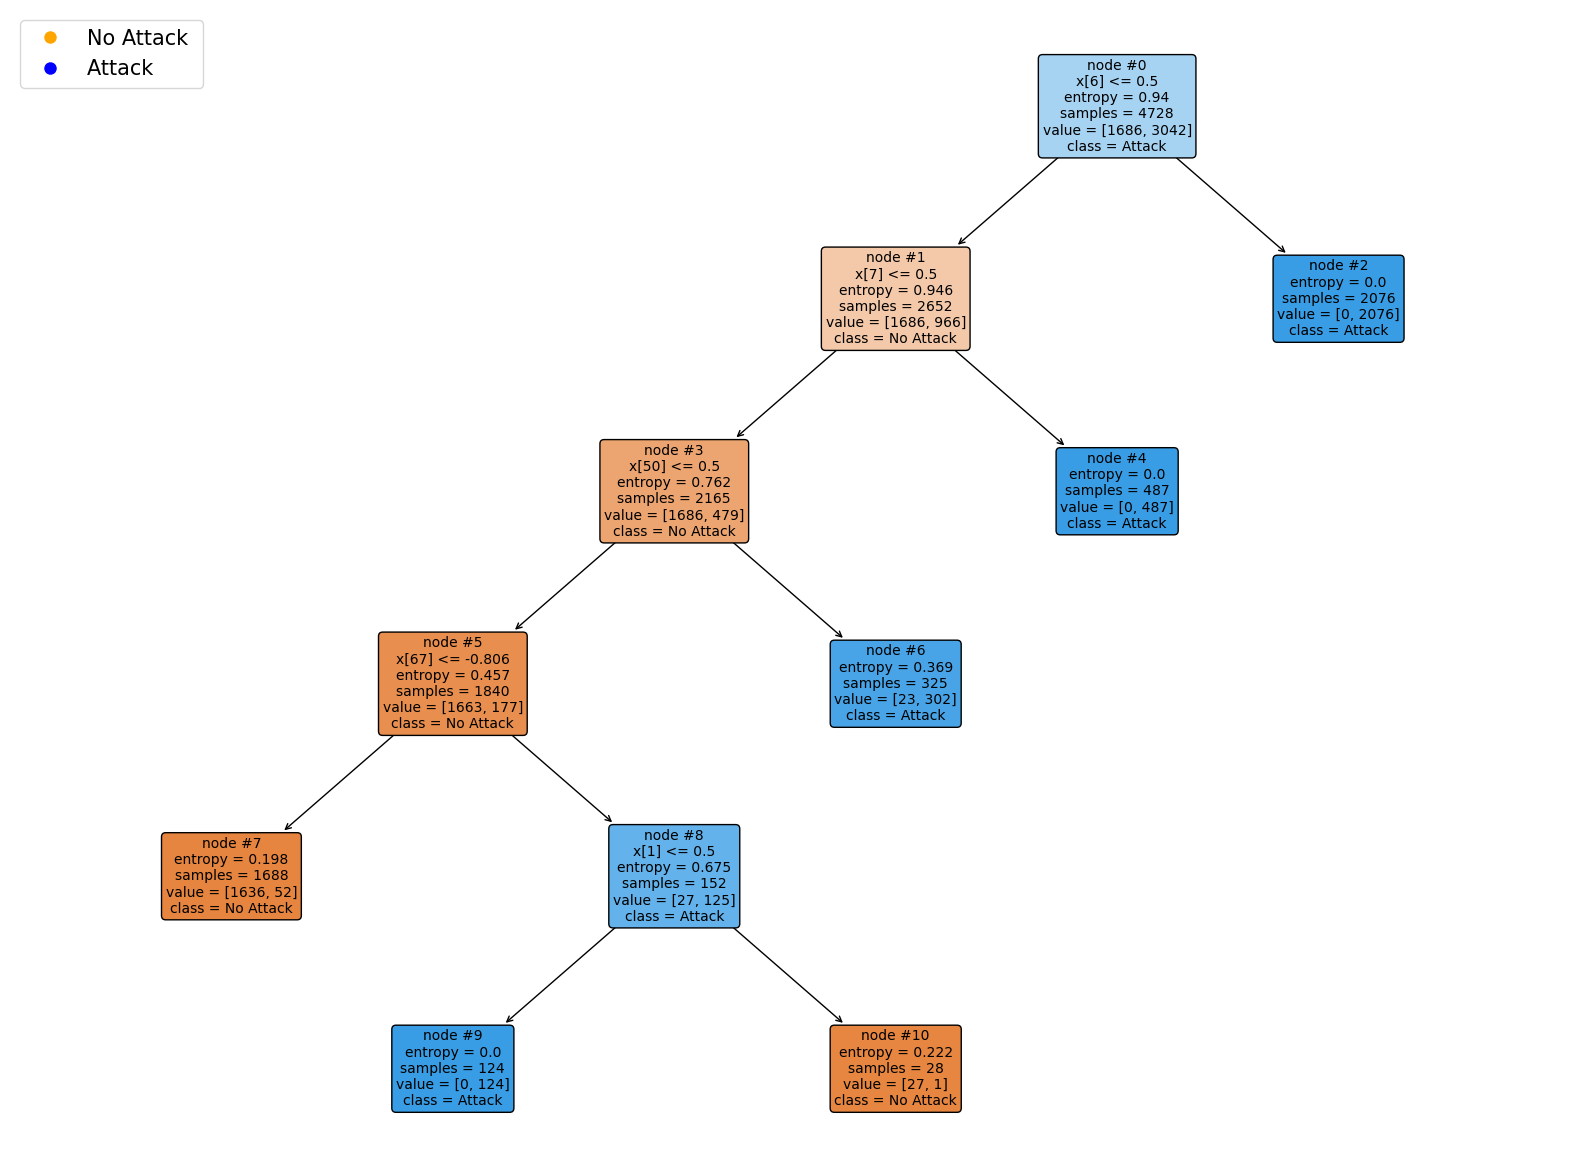

Node 0: Depth=0, Class=Attack, Samples=4728.0, Impurity=0.940
Node 1: Depth=1, Class=No Attack, Samples=2652.0, Impurity=0.946
Node 3: Depth=2, Class=No Attack, Samples=2165.0, Impurity=0.762
Node 5: Depth=3, Class=No Attack, Samples=1840.0, Impurity=0.457
Node 7: Depth=4, Class=No Attack, Samples=1688.0, Impurity=0.198
Node 8: Depth=4, Class=Attack, Samples=152.0, Impurity=0.675
Node 9: Depth=5, Class=Attack, Samples=124.0, Impurity=0.000
Node 10: Depth=5, Class=No Attack, Samples=28.0, Impurity=0.222
Node 6: Depth=3, Class=Attack, Samples=325.0, Impurity=0.369
Node 4: Depth=2, Class=Attack, Samples=487.0, Impurity=0.000
Node 2: Depth=1, Class=Attack, Samples=2076.0, Impurity=0.000


In [435]:
fig, ax = plt.subplots(figsize=(20, 15))

# We assign the colors according to the display of the plot_tree functionn
colors = ['Orange', 'Blue']
class_labels = ["No Attack", "Attack"]
legend_labels = [f'{label} ' for label, color in zip(class_labels, colors)]

plot_tree(clf, filled=True, ax=ax, fontsize=10, node_ids=True, class_names=class_labels, rounded=True)
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(legend_labels, colors)], loc='upper left', fontsize=15)
plt.show()

# Display node information and the Decision Tree
display_node(0)

Impurity is measured on a scale from 0 to 1, with 0 representing pure nodes (all samples have the same class) and 1 representing highly impure nodes (samples are evenly distributed across classes).

We can see in the image above how is represented for each node, the blue nodes representing an **Attack** and the oranges a **No Attack**, as well, the less light it means it has a less level of Impurity and is more sure of the output.

## Conclusion from Tree Decision Classifier model

It is important to check constant on our accuracies to check if the model is overfitting or underfitting, even if it's a great value of accuracy we have to make sure that it is matching our confusion matrix as well.

The best way to overcome the 
From the confusion matrix we can see that 
- Out of **796** Actual Attacks , **46** were predicted to be no attack, which we call false negative (FN).
- Out of **796** Actual attacks, **750** were predicted to be Attacks, which we call true positive (TP).



# KNeighbors Classifier

This algorithm is an unsupervised algorithm This metric depends totally on a distance metric. 

To use this model is important to know the number of K neighbors we want to implement, in this case we can implement our model with no parameters and it will be assigned the default 5 neighbors and the default metric is Minkowski p=2, being Euclidean distance.

The formula for Minkowski is a generalized formula of the Euclidean Distance and the Manhattan distance being p=1. 

$$ (\sum\limits _{i = 1} ^{k}{ {|x_{i} - y_{i}|}})^\frac{1}{p}  $$ 

The formula for Euclidean distance:

$$ \sqrt{\sum\limits _{i = 1} ^{k}{ {x_{i} - y_{i}}^2 } }$$ 

Which is  calculated as the square root of the sum of square differences between a new point x and a point that already exists y.

By calculating the Euclidean distance we got the nearest neighbors, it would find the nearest in category "No Attack" and the other nearest neighbors in category "Attack".

In [436]:
# Import the library KNeighbors Classifier 
from sklearn.neighbors import KNeighborsClassifier

In [437]:
# We implement knn with default parameters. n_neighbors = 5 metric = Euclidean distance.
knn = KNeighborsClassifier()

# We fit our data into the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [438]:
# We make the predictions of our model with X
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

In [439]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)
y_pred_test

# Create a dataframe for the confusion matrix
cm_df_knn = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df_knn)

print('\n\nInform of Classification:')
knn_report = classification_report(y_test, y_pred_test)
print(knn_report)

Predictions are 98.6% accurate on the training set.
Predictions are 97.6% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,445,7
Actual Attack,21,710




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.95      0.98      0.97       452
   No Attack       0.99      0.97      0.98       731

    accuracy                           0.98      1183
   macro avg       0.97      0.98      0.98      1183
weighted avg       0.98      0.98      0.98      1183



We can see that we got really good predictions and the sensitive is high as well, this means that n_neighbors= 5 have a really good accuracy, in other case if we used the default parameters we wouldn't be sure if the result would be the same, for this scenario we're going to try with the second dataset.

## Training the model with second dataset that has 2 features

In [440]:
# We implement knn with default parameters. n_neighbors = 5 metric = Euclidean distance.
knn = KNeighborsClassifier()

# We fit our data into the model
knn.fit(X_train2, y_train2)


KNeighborsClassifier()

In [441]:
y_pred_train = knn.predict(X_train2)
y_pred_test = knn.predict(X_test2)

In [442]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)

# Create a dataframe for the confusion matrix
cm_df_knn = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df_knn)

print('\n\nInform of Classification:')
report_knn = classification_report(y_test, y_pred_test)
print(report_knn)

Predictions are 97.2% accurate on the training set.
Predictions are 95.9% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,432,20
Actual Attack,28,703




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.94      0.96      0.95       452
   No Attack       0.97      0.96      0.97       731

    accuracy                           0.96      1183
   macro avg       0.96      0.96      0.96      1183
weighted avg       0.96      0.96      0.96      1183



For this dataset we could see that the accuracy decrease, meaning that this number of neighbors is good but we don't really know if is the optimal. The main step to do for the KNN neighbors is calculate

### Selelct our K value
How do we know what is the appropiate K for our model? We will implement a formmula that will range from different k_values from range 1 to 31, that will accuracy for each K and we will see based on the model we give which 

In [443]:
# Import seaborn to plot the k values according to accuracy scores
import seaborn as sns

#Using Cross Validation to Get the Best Value of k
def getK(X, y):
    k_values = [i for i in range (1,31)]
    scores = []

    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        #  It then uses cross_val_score to calculate the accuracy of the classifier using 5-fold cross-validation 
        score = cross_val_score(knn, X, y, cv=5)
        scores.append(np.mean(score))

    sns.lineplot(x = k_values, y = scores, marker = 'o')
    plt.grid()
    plt.xlabel("K Values")
    plt.ylabel("Accuracy Score")

Code to get best value of k [2].

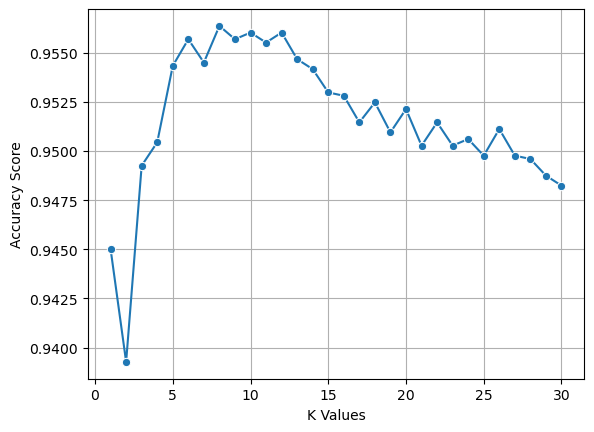

In [444]:
# Get the accuracy score from K-values from the second 
getK(TwoX, y)

In [445]:
# Do the model with n_neighbors 8
knn = KNeighborsClassifier(n_neighbors= 8)
knn.fit(X_train2, y_train2)

KNeighborsClassifier(n_neighbors=8)

In [446]:
y_pred_train = knn.predict(X_train2)
y_pred_test = knn.predict(X_test2)

In [447]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)
y_pred_test

# Create a dataframe for the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df)


report_knn = classification_report(y_test, y_pred_test)
print('\n\nInform of Classification:')
print(report_knn)

Predictions are 97.1% accurate on the training set.
Predictions are 96.4% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,437,15
Actual Attack,28,703




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.94      0.97      0.95       452
   No Attack       0.98      0.96      0.97       731

    accuracy                           0.96      1183
   macro avg       0.96      0.96      0.96      1183
weighted avg       0.96      0.96      0.96      1183



For the second dataset we can see that the sensitivity/recall: is 0.92 which is a good recall but we're going to compare to the first dataset and check if the model can improve with more features.

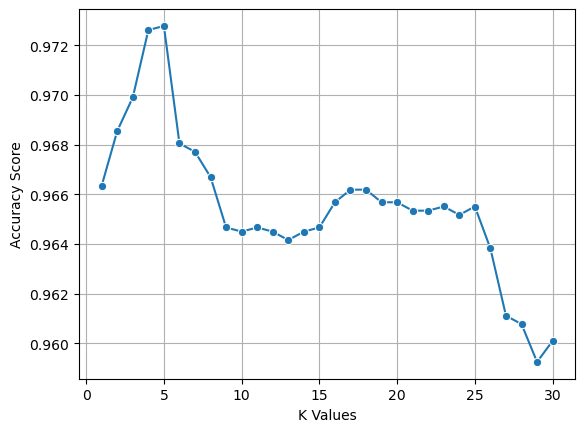

In [448]:
getK(X,y)

In the graph above, we see the most optimal K-values to use, in this case they can be 3 & 4. We will implement this value and train the model with both K_values to see which one is best.


## Training the model with n_neighbors = 4 and first dataset

In [449]:
knn = KNeighborsClassifier(n_neighbors= 4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [450]:
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

In [451]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)
y_pred_test

# Create a dataframe for the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df)

report_knn = classification_report(y_test, y_pred_test)

print('\n\nInform of Classification:')
print(report_knn)

Predictions are 98.7% accurate on the training set.
Predictions are 97.6% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,447,5
Actual Attack,23,708




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.95      0.99      0.97       452
   No Attack       0.99      0.97      0.98       731

    accuracy                           0.98      1183
   macro avg       0.97      0.98      0.98      1183
weighted avg       0.98      0.98      0.98      1183



## Training the model with n_neighbors = 3 and first dataset

In [452]:
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [453]:
# Measure memory usage
tracemalloc.start()

# Record the start time
start_time = time.time()

# Train or model with our first dataset
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, y_train)

# Calculate the execution time
end_time = time.time()

execution_time = end_time - start_time

current, peak = tracemalloc.get_traced_memory()
memory_usage[1] = current/ 10**3
tracemalloc.stop()

# Print or use the execution time as needed
computation_time[1] = execution_time

In [454]:
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

In [455]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)


# Create a dataframe for the confusion matrix
cm_df_knn = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df_knn)

report_knn = classification_report(y_test, y_pred_test)

models_name[1] = "Kneighbors"
accuracy_model[1] = (["{:.2f}".format(100*accuracy_train), "{:.2f}".format(100*accuracy_test)])

print('\n\nInform of Classification:')
print(report_knn)

Predictions are 99.1% accurate on the training set.
Predictions are 97.9% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,445,7
Actual Attack,18,713




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.96      0.98      0.97       452
   No Attack       0.99      0.98      0.98       731

    accuracy                           0.98      1183
   macro avg       0.98      0.98      0.98      1183
weighted avg       0.98      0.98      0.98      1183



## Conclusion from KNeighbors Classifier Model

Evaluating different number of neighbors following the best K-values for accuracy and also the two dataset, we choose to use the model with n_neighbors= 3 and the first dataset, since the predictions are higher and as well it predict more positive attacks compared to the other model where n_neighbors = 4. 

It is appreciated too the differents time execution between the models with the first dataset containing X all the features and the second dataset only containing Length and Delta. For the second dataset the code will be compute less times.

We will use the model of n=3 neighboors for this algorithm, since it predicts more attack as when is no attacks and is better to have false positives since it doesn't really presents an attack.

- Out of **796** Actual Attacks , **31** were predicted to be no attack, which we call false negative (FN).
- Out of **796** Actual attacks, **765** were predicted to be Attacks, which we call true positive (TP).


# Multivariate Logistic Regression Model  
This a type of analysis that can help predict results when working with multiple variables.
This logistic regression is called multivariate due to the fact that we have more than one independent variable -> multiple predictor variables (features). 

The formula for the probability of an event occurring in multivariate logistic regression can be expressed as follows:

Probability of Event (Y=1):

$$ P(Y=1) = \frac{1 }{(1 + e^{(-z)})} $$

- P(Y=1) is the probability of the event occurring.
- e is the base of the natural logarithm 
- z is the linear combination of predictor variables and their respective coefficients:

For z :
$$ z = β₀ + β₁X₁ + β₂X₂ + ... + βn*Xn $$

- β₀ is the intercept or bias term.
- β₁, β₂, ..., βn are the coefficients associated with each predictor variable X₁, X₂, ..., Xn.
- X₁, X₂, ..., Xn are the values of the predictor variables.


## Evaluate the model with second dataset containing two features being Delta and Length

In [456]:
from sklearn.linear_model import LogisticRegression

In [457]:
modelLR = LogisticRegression()
modelLR.fit(X_train2, y_train2)

LogisticRegression()

In [458]:
# Predict the labels for the train
y_pred_train = modelLR.predict(X_test2)
y_pred_test = modelLR.predict(X_test2)

In [459]:
#accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
#accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))
# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)

# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)


# Create a dataframe for the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df)
report_lr = classification_report(y_test, y_pred_test) 
print('\n\nInform of Classification:')
print(report_lr)

Predictions are 99.1% accurate on the training set.
Predictions are 97.9% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,451,1
Actual Attack,256,475




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.64      1.00      0.78       452
   No Attack       1.00      0.65      0.79       731

    accuracy                           0.78      1183
   macro avg       0.82      0.82      0.78      1183
weighted avg       0.86      0.78      0.78      1183



The model's accuracy drops to 77.0% in the test set compared to 94.7% in the training set. The lower accuracy on the test set compared to the training set indicates that the model may be overfitting the training data or can it can have limitations in its ability to generalize to new, unseen data.

## Evaluate the model with first dataset 

In [460]:
# Measure memory usage
tracemalloc.start()

# Record the start time
start_time = time.time()

# Train or model with our first dataset
modelLR = LogisticRegression()
modelLR.fit(X_train, y_train)


# Calculate the execution time
end_time = time.time()


execution_time = end_time - start_time

current, peak = tracemalloc.get_traced_memory()
memory_usage[2] = current/ 10**3
tracemalloc.stop()

# Print or use the execution time as needed
computation_time[2] = execution_time

In [461]:
# Predict the labels for the train
y_pred_train = modelLR.predict(X_test)
y_pred_test = modelLR.predict(X_test)

In [462]:
# Calculate precision
accuracy_ = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))

# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)


# Create a dataframe for the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df)

models_name[2] = "Logistic Regression"

accuracy_model[2] = (["{:.2f}".format(100*accuracy_train), "{:.2f}".format(100*accuracy_test)])
print('\n\nInform of Classification:')
print(report)

Predictions are 99.1% accurate on the training set.
Predictions are 97.0% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,445,7
Actual Attack,29,702




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.93      0.95      0.94       452
   No Attack       0.97      0.95      0.96       731

    accuracy                           0.95      1183
   macro avg       0.95      0.95      0.95      1183
weighted avg       0.95      0.95      0.95      1183



## Dummy Classifier
This classifier predicts the most frequent class according to the training data, it doesn't generate any insight about this data 

In [463]:
from sklearn.dummy import DummyClassifier

In [464]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
y_pred_train = dummy_clf.predict(X_train)
y_pred_test = dummy_clf.predict(X_test)

In [465]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))
# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)


# Create a dataframe for the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df)

models_name[3] = "Dummy Classifier"

accuracy_model[3] = (["{:.2f}".format(100*accuracy_train), "{:.2f}".format(100*accuracy_test)])
print('\n\nInform of Classification:')
print(report)

Predictions are 64.3% accurate on the training set.
Predictions are 61.8% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,0,452
Actual Attack,0,731




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.93      0.95      0.94       452
   No Attack       0.97      0.95      0.96       731

    accuracy                           0.95      1183
   macro avg       0.95      0.95      0.95      1183
weighted avg       0.95      0.95      0.95      1183



For the results, we can see that the confussion matrix is not really helpful since it only adds up to the predicted Attack, being the majority of counts by the model.
We need to add uniform so we can have predicted no attack & predicted attacks.

In [466]:
# Measure memory usage
tracemalloc.start()

# Record the start time
start_time = time.time()

dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)


# Calculate the execution time
end_time = time.time()


execution_time = end_time - start_time

current, peak = tracemalloc.get_traced_memory()
memory_usage[3] = current/ 10**3
tracemalloc.stop()

# Print or use the execution time as needed
computation_time[3] = execution_time

In [467]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)
y_pred_train = dummy_clf.predict(X_train)
y_pred_test = dummy_clf.predict(X_test)

In [468]:
y_pred_train = dummy_clf.predict(X_train)
y_pred_test = dummy_clf.predict(X_test)

In [469]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))
# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)


# Create a dataframe for the confusion matrix
cm_df = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

display(cm_df)

models_name[3] = "Dummy Classifier"

accuracy_model[3] = (["{:.2f}".format(100*accuracy_train), "{:.2f}".format(100*accuracy_test)])
print('\n\nInform of Classification:')
print(report)

Predictions are 48.6% accurate on the training set.
Predictions are 48.9% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,222,230
Actual Attack,374,357




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.93      0.95      0.94       452
   No Attack       0.97      0.95      0.96       731

    accuracy                           0.95      1183
   macro avg       0.95      0.95      0.95      1183
weighted avg       0.95      0.95      0.95      1183



## Random Forest
This model is consisted of multiple decision trees, where each tree independently classifies the data, and the final prediction is determined by a majority vote or the average of this predictions.

Since we have multiple trees in the model group, we are going to add  


Classification: Let $C^{b(x)} $ be the class prediction of the bth random-forest
tree. 

$$C^{B(x)} = majority vote {C^{b(x)}}$$

We will import the library RandomForestClassifier


In [470]:
from sklearn.ensemble import RandomForestClassifier

In [471]:
# Measure memory usage
tracemalloc.start()

# Record the start time
start_time = time.time()

forest_clf = RandomForestClassifier(max_depth=10)
forest_clf.fit(X_train,y_train)

# Calculate the execution time
end_time = time.time()

execution_time = end_time - start_time

current, peak = tracemalloc.get_traced_memory()
memory_usage[4] = current/ 10**3
tracemalloc.stop()

# Print or use the execution time as needed
computation_time[4] = execution_time

In [472]:
y_pred_train = forest_clf.predict(X_train)
y_pred_test = forest_clf.predict(X_test)

In [473]:
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Predictions are {:3.1f}% accurate on the training set.'.format(100*accuracy_train))
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Predictions are {:3.1f}% accurate on the test set.'.format(100*accuracy_test))
# Create matrix 
cm = confusion_matrix(y_test, y_pred_test)


# Create a dataframe for the confusion matrix
cm_df_forest = pd.DataFrame(cm, 
        index = ["Actual No Attack", "Actual Attack"], 
        columns= ["Predicted No Attack", "Predicted Attack"])

models_name[4] = "Random Forest Classifier"


accuracy_model[4] = (["{:.2f}".format(100*accuracy_train), 
                      "{:.2f}".format(100*accuracy_test)])
display(cm_df_forest)
print('\n\nInform of Classification:')
print(report)

Predictions are 99.1% accurate on the training set.
Predictions are 98.3% accurate on the test set.


,Predicted No Attack,Predicted Attack
Actual No Attack,446,6
Actual Attack,14,717




Inform of Classification:
              precision    recall  f1-score   support

      Attack       0.93      0.95      0.94       452
   No Attack       0.97      0.95      0.96       731

    accuracy                           0.95      1183
   macro avg       0.95      0.95      0.95      1183
weighted avg       0.95      0.95      0.95      1183



# We will implement a for to see the whole models in one cell and see which one is the most optimal

In [474]:
data = {
    'Model': models_name,
    'Computation Time': computation_time,
    'Memory Usage (KB)': memory_usage,
    'Predictions Training': [accuracy[0] for accuracy in accuracy_model],
    'Predictions Test': [accuracy[1] for accuracy in accuracy_model]
}

# Create a dataframe with our models and metrics
df = pd.DataFrame(data)
df

,Model,Computation Time,Memory Usage (KB),Predictions Training,Predictions Test
0,Decision Tree Classifier,1.000000,1.000,98.39,97.89
1,Kneighbors,0.004798,2651.818,99.11,97.89
2,Logistic Regression,0.077028,2703.642,99.11,96.96
3,Dummy Classifier,0.002391,3.402,48.65,48.94
4,Random Forest Classifier,0.482374,76.830,99.13,98.31


In [479]:
print(f"Higher Accuracy Model found: Random Forest Classifier")
display(cm_df_forest)

Higher Accuracy Model found: Random Forest Classifier


,Predicted No Attack,Predicted Attack
Actual No Attack,446,6
Actual Attack,14,717


# Conclusion

We can see that for dettecting an attack or not we have many models that can be suitable for this type of problem due the accuracy but it's important to consider computation time and memory usage. We followed also the confusion matrix since it’s more important to have more predicted **Attacks** in this case of problems, high sensitivity means that among people who actually have an **Attack** risk.

We've seen that the model with higher is KNeighbors since it has less attacks but we see that the memory usage is a lot and although the computation time is not that long it takes a lot of space. 



In [ ]:
# Try our model with Test data